In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Install required libraries
!pip install -qU python-gdcm pydicom pylibjpeg
!pip install -qU dicomsdl

# Standard library imports
import os
import time

# Third-party library imports
import numpy as np
import pandas as pd
import cv2
import pydicom
import dicomsdl

# Visualization library imports
import matplotlib.pyplot as plt

# Progress bar library imports
from tqdm.notebook import tqdm, trange

# Parallel processing library imports
from joblib import Parallel, delayed

In [2]:
import re
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
from kaggle_datasets import KaggleDatasets

Tensorflow version 2.6.4


In [3]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

2023-01-23 12:39:35.120984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 12:39:35.121892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 12:39:35.318133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 12:39:35.318970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 12:39:35.319721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Number of accelerators:  2


In [4]:
csv_path = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
train_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'
data = pd.read_csv(csv_path)

# get_paths
This function generates and returns a list of n paths of the DICOM files, using data from the CSV file. If desired, the paths can be shuffled to produce a random selection, otherwise, the paths will be returned in their original order. In addition to the paths, this function also returns a cache, which is a list of dictionaries that map the patient IDs and scan IDs for each file. If n is omitted, all paths are obtained

In [5]:
def get_paths(n: int=len(data), shuffle: bool=False):
    if shuffle == True:
        df = data.sample(frac=1, random_state=0)
    else:
        df = data
    paths = []
    ids_cache = []
    for i in range(n):
        patient = str(df.iloc[i]['patient_id'])
        scan = str(df.iloc[i]['image_id'])
        paths.append(train_path + '/' + patient + '/' + scan + '.dcm')
        ids_cache.append({'patient_id': patient, 'scan_id': scan})
    return paths, ids_cache


# Example
paths, _ = get_paths(n=5, shuffle=True)
paths

['/kaggle/input/rsna-breast-cancer-detection/train_images/58224/132390955.dcm',
 '/kaggle/input/rsna-breast-cancer-detection/train_images/21809/1307476428.dcm',
 '/kaggle/input/rsna-breast-cancer-detection/train_images/58351/1689606258.dcm',
 '/kaggle/input/rsna-breast-cancer-detection/train_images/60826/1465194139.dcm',
 '/kaggle/input/rsna-breast-cancer-detection/train_images/1250/1329687627.dcm']

# calculate_aspect_ratios
This function returns a list of the aspect ratios (height to width) of the images specified by the filepaths to DICOM files. An optional preprocessor can be provided, which can crop the images before the aspect ratios are calculated. The purpose of this is to have an idea of the average aspect ratio of the cropped images over the dataset. Maybe the mammograms do not necessarily need to be square (e.g. 256x256, 512x512, 1024x1024), and a different aspect ratio may be more appropriate in order to reduce the pixel distorsion (e.g. 256x512, 512x768, 1024x1280).

In [6]:
def calculate_aspect_ratios(paths: list, preprocessor=None):
    ratios = []
    for i in trange(len(paths)):
        if preprocessor:
            img = preprocessor.preprocess_single_image(paths[i])
        else:
            scan = pydicom.dcmread(paths[i])
            img = scan.pixel_array
        height, width = img.shape
        ratio = height / width
        ratios.append(ratio)
    return ratios


# Example
ratios = calculate_aspect_ratios(paths)
print("Ratios:", ratios)
print("Min:", np.min(ratios))
print("Max:", np.max(ratios))
print("Avg:", np.mean(ratios))

  0%|          | 0/5 [00:00<?, ?it/s]

Ratios: [1.3, 1.1985370950888192, 1.2307692307692308, 1.279030910609858, 1.0895218718209563]
Min: 1.0895218718209563
Max: 1.3
Avg: 1.219571821657773


In [7]:
class MammographyPreprocessor():
    
    # Constructor
    def __init__(self, size: tuple=None, breast_side: str='L',
                 csv_path=None, train_path=None):
        self.size = size
        os.makedirs(os.getcwd(), exist_ok=True)
        self.breast_side = breast_side
        assert breast_side in ['L', 'R'], "breast_side should be 'L' or 'R'"
        # implement the paths of the original RSNA dataset (V2)
        self.csv_path = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
        self.train_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'
        if csv_path:
            self.csv_path = csv_path
        if train_path:
            self.train_path = train_path
        self.df = pd.read_csv(self.csv_path)
    
    # Get the paths from the preprocessor (V2)
    def get_paths(self, n: int=None, shuffle: bool=False, return_cache: bool=False):
        if n == None:
            n = len(self.df)
        if shuffle == True:
            df = self.df.sample(frac=1, random_state=0).copy()
        else:
            df = self.df.copy()
        paths = []
        ids_cache = []
        for i in range(n):
            patient = str(df.iloc[i]['patient_id'])
            scan = str(df.iloc[i]['image_id'])
            paths.append(self.train_path + '/' + patient + '/' + scan + '.dcm')
            ids_cache.append({'patient_id': patient, 'scan_id': scan})
        if return_cache:
            return paths, ids_cache
        else:
            return paths
    
    # Read from a path and convert to image array
    def read_image(self, path: str):
        scan = pydicom.dcmread(path)
        img = scan.pixel_array
        return img
    
    # Apply the preprocessing methods on one image
    def preprocess_single_image(self, path: str, save: bool=False,
                                save_dir: str=None, png: bool=True):
        scan = dicomsdl.open(path)
        img = scan.pixelData()
        img = self._fix_photometric_interpretation(img, scan)
        img = self._windowing(img, scan)
        img = self._normalize_to_255(img)
        img = self._flip_breast_side(img, scan)
        img = self._crop(img)
        if self.size:
            img = self._resize(img)
        if save:
            self._save_image(img, path, png, save_dir)
        return img
    
    # Preprocess all the images from the paths
    def preprocess_all(self, paths: list, save: bool=True,
                       save_dir: str='train_images', png: bool=True,
                       parallel: bool=False, n_jobs: int=4):
        clock = time.time()
        if parallel:
            Parallel(n_jobs=n_jobs) \
            (delayed(self.preprocess_single_image) \
            (path, save, save_dir, png) for path in tqdm(paths, total=len(paths)))
            print("Parallel preprocessing done!")
        else:
            for i in trange(len(paths)):
                self.preprocess_single_image(paths[i], save, save_dir, png)
            print("Sequential preprocessing done!")
        print("Time =", np.around(time.time() - clock, 3), 'sec')
    
    # Display the images from the dicom paths with optional preprocessing
    def display(self, paths: list, rows: int, cols: int,
                preprocess: bool=False, cmap='bone', cbar: bool=False,
                save_fig: bool=False, save_name: str='myplot.png'):
        assert len(paths) >= (rows * cols), \
        f"Not enough paths for the display. " \
        f"Please give at least {rows * cols} paths."
        plt.figure(figsize=(18, 26 * rows / cols))
        for i in trange(rows * cols):
            path = paths[i]
            if preprocess:
                img = self.preprocess_single_image(path, save=False)
            else:
                img = self.read_image(path)
            plt.subplot(rows, cols, i+1)
            plt.imshow(img, cmap=cmap)
            if cbar:
                plt.colorbar()
            plt.grid(False)
            plt.title(path.split('/')[-1][:-4])
        plt.suptitle("Preprocessed images" if preprocess \
                     else "Raw images", fontsize=25)
        if save_fig:
            plt.savefig(save_name, facecolor='white')
        plt.show()
    
    # Adjust the contrast of an image
    def _windowing(self, img, scan):
        function = scan.VOILUTFunction
        if type(scan.WindowWidth) == list:
            center = scan.WindowCenter[0]
            width = scan.WindowWidth[0]
        else:
            center = scan.WindowCenter
            width = scan.WindowWidth
        y_range = 2**scan.BitsStored - 1
        if function == 'SIGMOID':
            img = y_range / (1 + np.exp(-4 * (img - center) / width))
        else: # LINEAR
            below = img <= (center - width / 2)
            above = img > (center + width / 2)
            between = np.logical_and(~below, ~above)
            img[below] = 0
            img[above] = y_range
            img[between] = ((img[between] - center) / width + 0.5) * y_range
        return img
    
    # Interpret pixels in a consistant way
    def _fix_photometric_interpretation(self, img, scan):
        if scan.PhotometricInterpretation == 'MONOCHROME1':
            return img.max() - img
        elif scan.PhotometricInterpretation == 'MONOCHROME2':
            return img - img.min()
        else:
            raise ValueError("Invalid Photometric Interpretation: {}"
                               .format(scan.PhotometricInterpretation))
    
    # Cast into 8-bits for saving
    def _normalize_to_255(self, img):
        if img.max() != 0:
            img = img / img.max()
        img *= 255
        return img.astype(np.uint8)
    
    # Flip the breast horizontally on the chosen side 
    def _flip_breast_side(self, img, scan):
        img_breast_side = self._determine_breast_side(img)
        if img_breast_side == self.breast_side:
            return img
        else:
            return np.fliplr(img)    
    
    # Determine the current breast side
    def _determine_breast_side(self, img):
        col_sums_split = np.array_split(np.sum(img, axis=0), 2)
        left_col_sum = np.sum(col_sums_split[0])
        right_col_sum = np.sum(col_sums_split[1])
        if left_col_sum > right_col_sum:
            return 'L'
        else:
            return 'R'
    
    # Crop the useless background of the image
    def _crop(self, img):
        bin_img = self._binarize(img, threshold=5)
        contour = self._extract_contour(bin_img)
        img = self._erase_background(img, contour)
        x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])
        y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])
        x1, x2 = int(0.99 * x1), int(1.01 * x2)
        y1, y2 = int(0.99 * y1), int(1.01 * y2)
        return img[y1:y2, x1:x2]
    
    # Binarize the image at the threshold
    def _binarize(self, img, threshold):
        return (img > threshold).astype(np.uint8)
    
    # Get contour points of the breast
    def _extract_contour(self, bin_img):
        contours, _ = cv2.findContours(
            bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contour = max(contours, key=cv2.contourArea)
        return contour
    
    # Set to background pixels of the image to zero
    def _erase_background(self, img, contour):
        mask = np.zeros(img.shape, np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
        output = cv2.bitwise_and(img, mask)
        return output
    
    # Resize the image to the preprocessor size
    def _resize(self, img):
        return cv2.resize(img, self.size)
    
    # Get the save path of a given dicom file
    def _get_save_path(self, path, png, save_dir):
        patient = path.split('/')[-2]
        filename = path.split('/')[-1]
        if png:
            filename = filename.replace('dcm', 'png')
        else:
            filename = filename.replace('dcm', 'jpeg')
        if save_dir:
            save_path = os.path.join(os.getcwd(), save_dir, patient, filename)
        else:
            save_path = os.path.join(os.getcwd(), patient, filename)
        return save_path
    
    # Save the preprocessed image
    def _save_image(self, img, path, png, save_dir):
        save_path = self._get_save_path(path, png, save_dir)
        patient_folder = os.path.split(save_path)[0]
        os.makedirs(patient_folder, exist_ok=True)
        cv2.imwrite(save_path, img)

In [8]:
# Test with 100 files 
paths, _ = get_paths(n=100, shuffle=True)

In [9]:
mp = MammographyPreprocessor(size=(256, 256))
mp

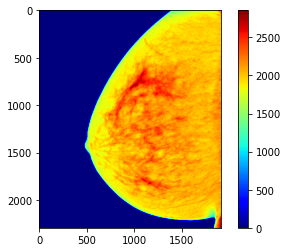

In [10]:
# Select the first file of the list
path = paths[12]

# Load the image array
img = mp.read_image(path=path)

# Display what has been loaded
plt.imshow(img, cmap='jet')
plt.colorbar()
plt.show()

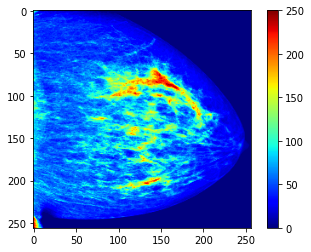

In [11]:
# Preprocess from the same previous path
img = mp.preprocess_single_image(path=path, save=False)

# Display the preprocessed image
plt.imshow(img, cmap='jet')
plt.colorbar()
plt.show()


In [12]:
mp.preprocess_all(paths, save=True, save_dir='train_images', parallel=True, n_jobs=4)

  0%|          | 0/100 [00:00<?, ?it/s]

Parallel preprocessing done!
Time = 64.338 sec


  0%|          | 0/15 [00:00<?, ?it/s]

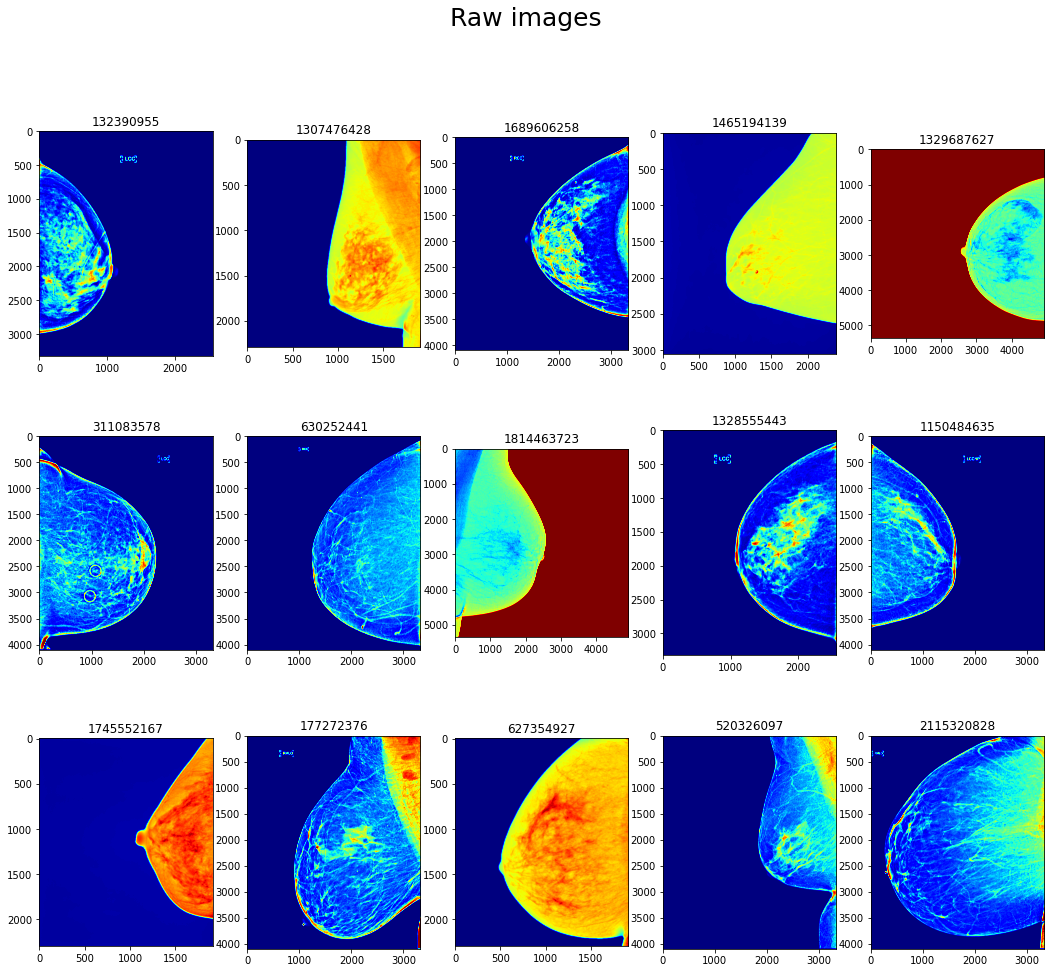

In [13]:
# Images before preprocessing
mp.display(paths, rows=3, cols=5, preprocess=False, cmap='jet', save_fig=False)

  0%|          | 0/15 [00:00<?, ?it/s]

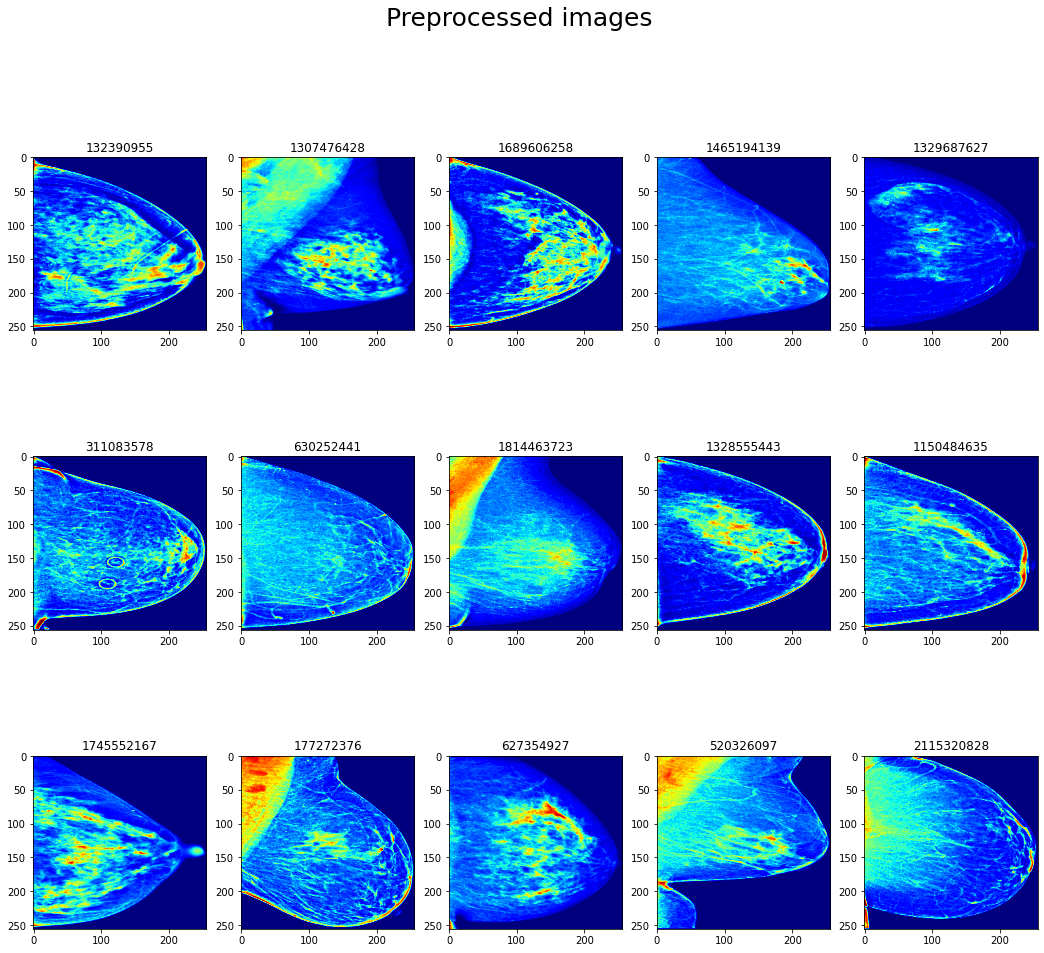

In [14]:
# Images after preprocessing
mp.display(paths, rows=3, cols=5, preprocess=True, cmap='jet', save_fig=False)

In [15]:
# Get more file paths
paths, _ = get_paths(n=300, shuffle=True)

# Create a new preprocessor with no resize value
mp = MammographyPreprocessor()

# Calculate the size ratios with the preprocessor
ratios = calculate_aspect_ratios(paths, preprocessor=mp)
print("Min ratio:", np.min(ratios))
print("Max ratio:", np.max(ratios))
print("Med ratio:", np.median(ratios))


  0%|          | 0/300 [00:00<?, ?it/s]

Min ratio: 1.2772277227722773
Max ratio: 4.713375796178344
Med ratio: 2.096771760813507


  0%|          | 0/25 [00:00<?, ?it/s]

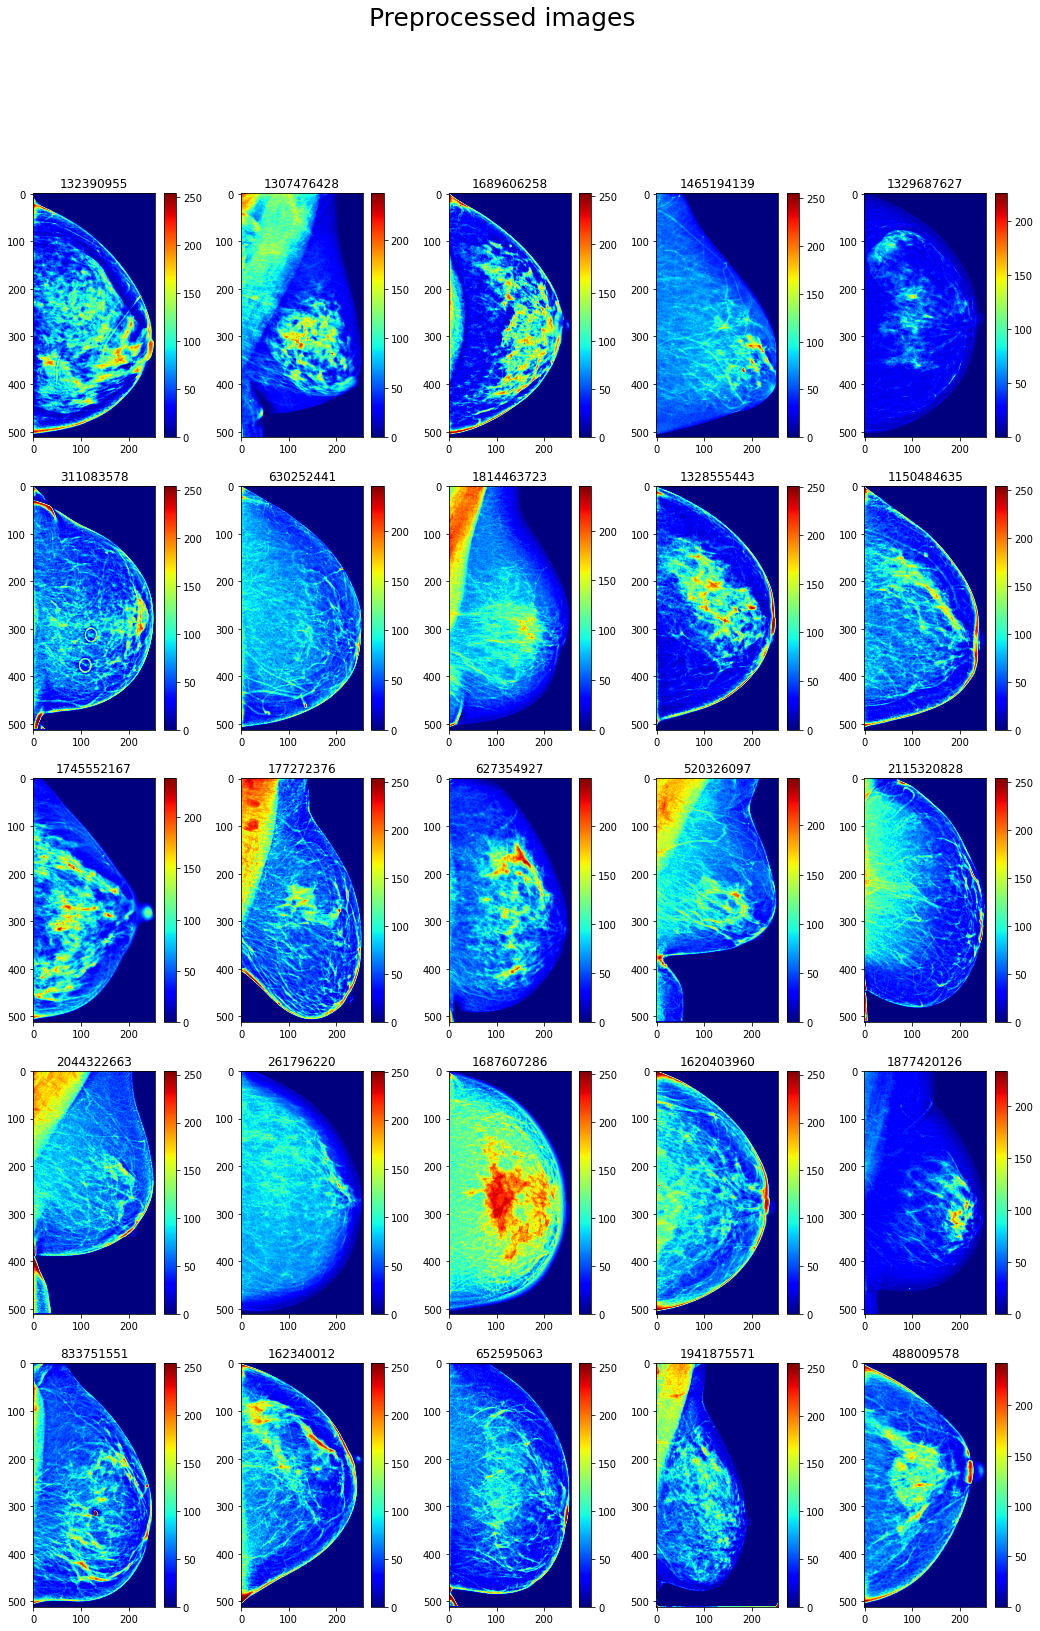

In [16]:
# Define first the new size value
mp = MammographyPreprocessor(size=(256, 512)) # OpenCV convention (Width x Height)
mp.display(paths, rows=5, cols=5, preprocess=True, cmap='jet', cbar=True, save_fig=False)